In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Daten laden
df = pd.read_csv(r"C:\Users\valen\OneDrive\Dokumente\01_Studium\9\Probabilistic ML\Local\player_stats_clean.csv")
df.columns = df.columns.str.strip()



# Featureliste (in 04Feature definiert)
feature_list = [
"SCA90","GCA90","KP","PPA","1/3","CrsPA","PrgP","Int","Clr",
    "Touches","TeamSuccess+/-90","TeamSuccess(xG)xG+/-90","StandardSh/90","StandardSoT/90"
]

X = df[feature_list].copy()

In [2]:
# Fehlende Werte 
mask = X.isna().sum(axis=1) <= 2   # z.B. max. 2 NaNs erlauben
X = X[mask]
df = df.loc[X.index]
X = X.fillna(X.mean()) # auffüllen mit mean

In [3]:
# Varianz-Filter, Spalten ohne Streuung raus
vt = VarianceThreshold(threshold=0.01)
X_v = vt.fit_transform(X)
feat_v = X.columns[vt.get_support()]

In [4]:
# Korrelations-Filter (r > 0.95), reduntante Spalten entfernen
corr = pd.DataFrame(X_v, columns=feat_v).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
X_f = pd.DataFrame(X_v, columns=feat_v).drop(columns=to_drop) if to_drop else pd.DataFrame(X_v, columns=feat_v)

In [5]:
# Skalieren, Features vergleichbar machen
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_f)

In [12]:
# ======= Hier Unterschied zu KMeans
# BIC-Suche für beste k & covariance_type
K_RANGE = range(2, 11)
cov_types = ["full", "tied", "diag", "spherical"]
# full: pro Cluster volle Kovarianzmatrix, sehr flexibel
# tied: alle Cluster teilen sich eine Kovarianz
# diag: nur Variablenvarianzen, keine Korrelationen
# spherical: Kugeln, gleich in alle Richtungen

bic_rows = []
for cov in cov_types:
    for k in K_RANGE:
        gmm_tmp = GaussianMixture(
            n_components=k, # Anzahl Cluster
            covariance_type=cov, # Ellipsenformannahme
            random_state=42, # Reproduzierbarkeit
            reg_covar=1e-6, # Stabilisierung der Kovarianz
            init_params="kmeans", # startet nahe einer KMeans Lösung -> schneller/stabiler
            n_init=3 # probiert es 3x und nimmt die Beste
        ).fit(X_scaled)
        bic_rows.append({"k": k, "cov": cov, "bic": gmm_tmp.bic(X_scaled)}) # Rechnet den BIC für die trainierte Kombination aus und speichert ein Dict

bic_df = pd.DataFrame(bic_rows) # Umwandlung in ein Data Frame
best_row = bic_df.loc[bic_df["bic"].idxmin()] # Findet die Zeile mit dem kleinsten BIC, also die beste Kombi
# Extrahiert die optimale Clusterzahl und den optimalen Kovarianz Typ aus best_row
k_opt = int(best_row["k"])
cov_opt = str(best_row["cov"])

print("Beste Wahl laut BIC:", {"k": k_opt, "cov": cov_opt})

Beste Wahl laut BIC: {'k': 9, 'cov': 'diag'}


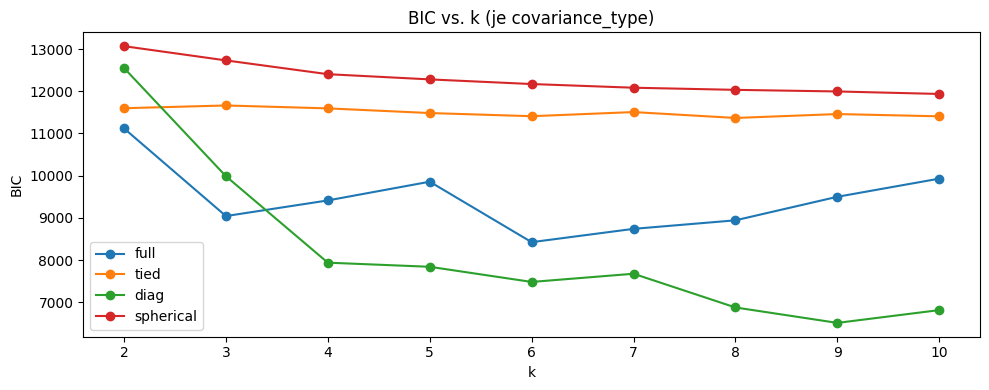

In [7]:
# BIC-Plot
plt.figure(figsize=(10,4))
for cov in cov_types:
    part = bic_df[bic_df["cov"]==cov]
    plt.plot(part["k"], part["bic"], "-o", label=cov)
plt.legend(); plt.title("BIC vs. k (je covariance_type)"); plt.xlabel("k"); plt.ylabel("BIC")
plt.tight_layout(); plt.show()

In [8]:
# GMM fitten
gmm = GaussianMixture(
    n_components=k_opt,
    covariance_type=cov_opt,
    random_state=42,
    reg_covar=1e-6,
    init_params="kmeans",
    n_init=5
).fit(X_scaled)

labels = gmm.predict(X_scaled) # hartes Label (welches Cluster)
proba  = gmm.predict_proba(X_scaled) # p(Zuordnung) je Cluster
max_p  = proba.max(axis=1)  # Sicherheit (wie nahe Spieler in seinem Cluster ist, 1=typisch, gegen 0= Grenzfall/Hybrid)

df['Cluster'] = labels
df['Cluster_p'] = max_p

In [9]:
# Zentren im Originalmaßstab
centers_scaled = gmm.means_
centers = pd.DataFrame(
    scaler.inverse_transform(centers_scaled),
    columns=X_f.columns,
    index=[f"Cluster {i}" for i in range(k_opt)]
)
print("\nGMM-Clusterzentren (Originalmaßstab):")
print(centers.round(3))


GMM-Clusterzentren (Originalmaßstab):
           SCA90  GCA90      KP    PPA     1/3  CrsPA    PrgP    Int    Clr  \
Cluster 0  0.733 -0.000   0.451  0.356   5.809  0.000   5.780  1.443  6.944   
Cluster 1  3.603  0.513   4.297  5.391   6.678  3.688   8.692  1.605  4.101   
Cluster 2  5.005  0.355  10.504  7.318  11.243  1.438  20.875  1.752  1.625   
Cluster 3  2.015  0.122   2.224  2.377  10.569  1.216  12.649  3.215  7.856   
Cluster 4  3.510  0.616   4.689  2.937   4.340  0.619   7.393  0.911  2.435   
Cluster 5  1.936  0.233   2.048  1.281  11.123  0.000  11.566  2.553  7.162   
Cluster 6  2.834 -0.000   2.296  1.733   2.264  0.616   3.803  0.490  1.511   
Cluster 7  2.766  0.188   6.159  5.540  31.859  1.623  33.505  4.226  9.971   
Cluster 8  1.620  0.249   1.937  1.672   3.191  1.226   4.877  1.384  6.243   

           Touches  TeamSuccess+/-90  TeamSuccess(xG)xG+/-90  StandardSh/90  \
Cluster 0  148.873            -0.393                  -0.257          0.349   
Cluster 1  1

In [10]:
# PCA für Visualisierung
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_scaled)

print("Erklärte Varianzanteile:", pca.explained_variance_ratio_)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X_f.columns
)
print(loadings)

Erklärte Varianzanteile: [0.31852754 0.21917568]
                             PC1       PC2
SCA90                   0.287328  0.316288
GCA90                   0.135076  0.178989
KP                      0.369950  0.167319
PPA                     0.366217  0.125886
1/3                     0.334931 -0.284520
CrsPA                   0.255234  0.088758
PrgP                    0.396097 -0.211198
Int                     0.197048 -0.296656
Clr                     0.071765 -0.392508
Touches                 0.340242 -0.334974
TeamSuccess+/-90        0.232099  0.058306
TeamSuccess(xG)xG+/-90  0.234621  0.135421
StandardSh/90           0.129126  0.408231
StandardSoT/90          0.093107  0.384684


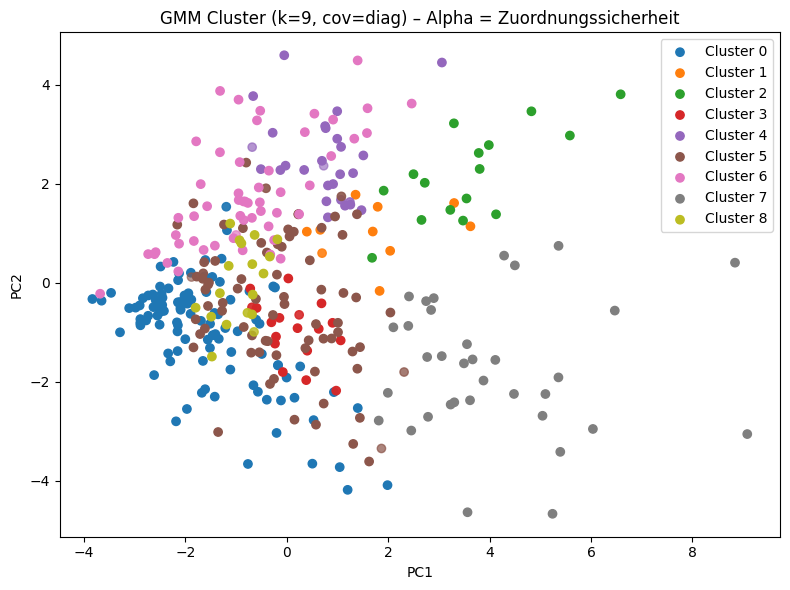

In [11]:
# PCA-Scatter mit Alpha = Sicherheit
plt.figure(figsize=(8,6))
for c in range(k_opt):
    m = (df['Cluster'] == c).values
    plt.scatter(
        pcs[m,0], pcs[m,1],
        label=f"Cluster {c}",
        alpha=np.clip(df.loc[m, 'Cluster_p'], 0.2, 1.0)
    )
plt.legend(); plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"GMM Cluster (k={k_opt}, cov={cov_opt}) – Alpha = Zuordnungssicherheit")
plt.tight_layout(); plt.show()

In [19]:
# ===== Tabellarische Ausgabe, soft Clusters zu jedem Spieler
# DataFrame bauen
proba_df = pd.DataFrame(
    proba,
    columns=[f"Cluster_{i}_proba" for i in range(gmm.n_components)],
    index=df.index
)

# Hartes Label + Sicherheit
hard = proba_df.values.argmax(axis=1)
conf = proba_df.max(axis=1)

# Alles zusammen mit Name/Position
cols_keep = []
if "Player" in df.columns: cols_keep.append("Player")
if "PrimaryPosGrp" in df.columns: cols_keep.append("PrimaryPosGrp")

out = pd.concat([df[cols_keep], proba_df], axis=1)
out["Cluster_hard"] = hard
out["Cluster_confidence"] = conf  # z.B. 0.60 = 60%

# Sortieren: erst nach Cluster, dann nach Sicherheit absteigend
out = out.sort_values(by=["Cluster_hard", "Cluster_confidence"], ascending=[True, False])
# Runden auf 6 Stellen
out = out.round(8)

# Anzeigen
print(out.head(20).to_string(index=False))

# Optional: als CSV speichern
out.to_csv("players_gmm_soft_assignments.csv", index=False)

           Player  Cluster_0_proba  Cluster_1_proba  Cluster_2_proba  Cluster_3_proba  Cluster_4_proba  Cluster_5_proba  Cluster_6_proba  Cluster_7_proba  Cluster_8_proba  Cluster_hard  Cluster_confidence
  Saba Kvirkvelia              1.0              0.0              0.0              0.0              0.0              0.0              0.0              0.0              0.0             0                 1.0
       Ezri Konsa              1.0              0.0              0.0              0.0              0.0              0.0              0.0              0.0              0.0             0                 1.0
     Guram Kashia              1.0              0.0              0.0              0.0              0.0              0.0              0.0              0.0              0.0             0                 1.0
 Paweł Dawidowicz              1.0              0.0              0.0              0.0              0.0              0.0              0.0              0.0              0.0          